### Walker experiment

In [1]:
import os, sys
%env CUDA_VISIBLE_DEVICES=0
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import joblib
from datetime import datetime
print("Numpy: {}, Torch: {}, Joblib: {}".format(np.__version__, torch.__version__, joblib.__version__))
assert joblib.__version__ == '0.9.4', 'this is important for global_variables. proceed at your own risk.'

env: CUDA_VISIBLE_DEVICES=0
Numpy: 1.15.2, Torch: 1.0.1.post2, Joblib: 0.9.4


__Download__ vertices and hnsw edges, prepare paths and ground truth neighbors

In [2]:
DATA_DIR = './data/DEEP100K'

if not os.path.exists(DATA_DIR):
    assert not DATA_DIR.endswith(os.sep), 'please do not put "/" at the end of DATA_DIR'
    !mkdir -p {DATA_DIR}
    !wget https://www.dropbox.com/sh/oc8tswkzrdqe4vi/AADSOL74QIBtg_EvOdBYOX3na?dl=1 -O {DATA_DIR}/deep_100k.zip
    !wget https://www.dropbox.com/s/ovabjrgxalfpqhz/deep100k_100000q_path_cache_margin5.bin?dl=1 -O {DATA_DIR}/deep100k_100000q_path_cache_margin5.bin
    !cd {DATA_DIR} && unzip deep_100k.zip

In [3]:
import lib
import os.path as osp

graph_params = { 
    'vertices_path': osp.join(DATA_DIR, 'deep_base.fvecs'),
    'edges_path': osp.join(DATA_DIR, 'test_hnsw100k_M8_ef300_onelevel1.ivecs'),
    'initial_vertex_id': 0,         # by default, starts search from this vertex
#     'info_path': osp.join(DATA_DIR, 'test_hnsw100k_M8_ef300_levels.bin'),
#     ^-- uncomment this to get hierarchical nsw
    
    'train_queries_path': osp.join(DATA_DIR, 'deep_learn.fvecs'),
    'test_queries_path': osp.join(DATA_DIR, 'deep_query.fvecs'),
    
    'train_gt_path': osp.join(DATA_DIR, 'train_gt.ivecs'),
    'test_gt_path': osp.join(DATA_DIR, 'test_gt.ivecs'),
#     ^-- comment these 2 lines to re-compute ground truth ids (if you don't have pre-computed ground truths)

    'ground_truth_n_neighbors': 1,  # for each query, finds this many nearest neighbors via brute force
}
graph = lib.Graph(**graph_params)

bin_path = osp.join(DATA_DIR, 'deep100k_%iq_path_cache_margin5.bin' % len(graph.train_queries))
# ^-- precomputed paths. leave empty string to compute manually
cache_path = osp.join(DATA_DIR, 'deep100k_%iq_path_cache_margin5.cache' % len(graph.train_queries))

__HNSW parameters:__ distance computation budget, reranking budget, metrics

In [4]:
total_dcs = 128

routing_dcs = 120
routing_vector_size = 96
verification_top_k = 8

architecture = 'gcn'      # 'gcn' or 'ffn' or whatever you define manually
max_batches  = 60000       # num training iterations; use float('inf') for unlimited

# one cycle learning rate schedule
learning_rate_base = 1e-3
warmup_steps = 5000
decay_rate = 1./3
learning_rate_min = 1e-5
batch_size = 1024
dev_batch_size = 100

# batch generator
sampling_temperature = 1.0
sampling_chunk_size = 10000
n_jobs = 8
margin = 5

exp_name = '{data_name}_dcs{total_dcs}_{architecture}_size{routing_vector_size}_routing{routing_dcs}_verification{verification_top_k}'.format(
    data_name=osp.split(DATA_DIR)[-1], total_dcs=total_dcs, routing_vector_size=routing_vector_size, routing_dcs=routing_dcs,
    verification_top_k=verification_top_k, architecture=architecture
)
print('exp name:', exp_name)
!rm {'./runs/' + exp_name} -rf # KEEP COMMENTED!
assert not os.path.exists('./runs/' + exp_name)

original_vector_size = graph.vertices.shape[-1]
is_compressed = (routing_vector_size != graph.vertices.shape[1])
if not is_compressed:
    projection_cost = 0
else:
    projection_cost = routing_vector_size 
sanity_check_dcs = round(routing_dcs * routing_vector_size / original_vector_size + projection_cost + verification_top_k)
assert total_dcs == sanity_check_dcs, "current scheme has {} dcs out of {} required".format(sanity_check_dcs, total_dcs)


exp name: DEEP100K_dcs128_gcn_size96_routing120_verification8


In [5]:
hnsw = lib.hnsw.WalkerHNSW(graph, max_dcs=routing_dcs,
                           top_vertices_for_verification=verification_top_k,
                           distance_for_verification=lib.hnsw.DISTANCES['euclidian'],
                           distance_for_routing=lib.hnsw.DISTANCES['negative_dot'],
                           hierarchical=False
)

__Pre-compute optimal paths__ to ground truth vertices (used as expert policy for training)

In [6]:
from lib.paths import Dijkstra, PathCache

# !rm -rf {cache_path}  # KEEP COMMENTED!
if os.path.exists(cache_path):
    path_cache = PathCache(cache_path, Dijkstra(graph), margin=margin)
elif os.path.exists(bin_path):
    # export from binary format
    path_cache = PathCache(cache_path, Dijkstra(graph), reset_cache=True, margin=margin)
    path_cache.export_from_bin(bin_path)
else:
    # compute manually (this can take hours)
    path_cache = PathCache(cache_path, Dijkstra(graph), reset_cache=True, margin=margin)
    initial_vertices = [
        hnsw.get_initial_vertex_id(query=graph.train_queries[i])
        for i in range(len(graph.train_queries))
    ]
    path_cache.prepare_paths(
        initial_vertices, graph.train_gt.cpu().data[:, 0].numpy(),
        batch_size=1024, pool=12, #make sure batch_size >> pool
    )

__Agent and Trainer__

In [7]:
from tensorboardX import SummaryWriter

if architecture == 'gcn':
    agent = lib.walker_agent.GCNWalkerAgent(
        graph.vertices.shape[1], conv_hid_size=256, hidden_size=1024, output_size=routing_vector_size, 
        residual=not is_compressed, project_query=is_compressed
    ).to(device='cuda')

elif architecture == 'ffn':
    agent = lib.walker_agent.SimpleWalkerAgent(
        graph.vertices.shape[1], hidden_size=4096, output_size=routing_vector_size, 
        residual=not is_compressed, project_query=is_compressed
    ).to(device='cuda')

else:
    raise ValueError("Unknown architecture: {}".format(architecture))

trainer = lib.SupervisedWalkerTrainer(
    agent, hnsw, path_cache, writer=SummaryWriter('runs/' + exp_name),
    learning_rate_base=learning_rate_base, warmup_steps=warmup_steps,
    decay_rate=decay_rate, learning_rate_min=learning_rate_min,
)

__Training loop__

In [8]:
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

train_loss_history, train_acc_history, dev_recall_history, total_dev_recall_history = [], [], [], []

In [9]:
# generates batches of [queries, ground truth]
dev_batcher = lib.utils.iterate_minibatches(graph.test_queries, graph.test_gt, batch_size=dev_batch_size)

# generates batches of [records] for training
train_batcher = trainer.generate_training_batches(
    graph.train_queries, graph.train_gt,
    queries_per_chunk=sampling_chunk_size, batch_size_max=batch_size,
    sampling_temperature=sampling_temperature, n_jobs=n_jobs,
)

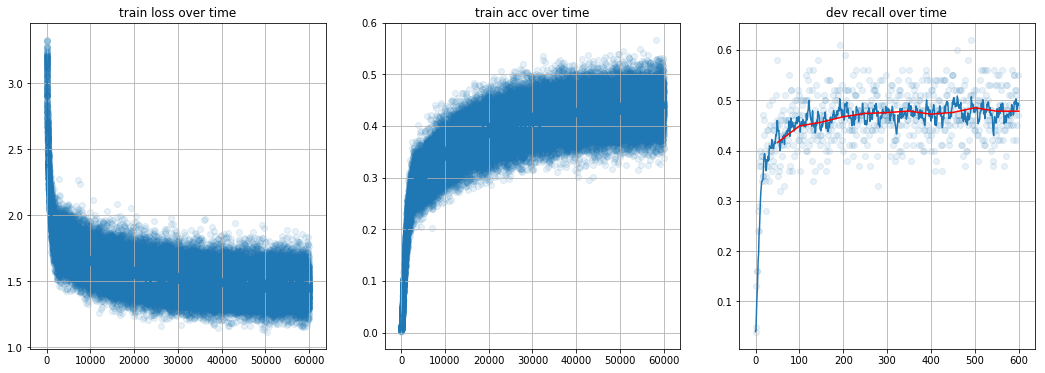

step=60000, mean_loss=1.442, time=0.778
____________________________________________________________________________________________________
.

In [10]:
for batch_records in train_batcher:
    metrics_t = trainer.train_on_batch(batch_records)
    train_loss_history.append(metrics_t['loss'].item())
    train_acc_history.append(metrics_t['acc'].item())
    print(end='.')
    
    if trainer.step % 100 == 0:
        dev_metrics_t = trainer.compute_dev_metrics_on_batch(*next(dev_batcher))
        dev_recall_history.append(dev_metrics_t['recall'])
    
    if trainer.step % 5000 == 0:
        print(end="Saving...")
        torch.save(agent, "runs/{}/agent.{}.pth".format(exp_name, trainer.step))
        torch.save(trainer.opt, "runs/{}/opt.{}.pth".format(exp_name, trainer.step))
        print('Done!')
        print('Compute metrics for all test queries...')
        total_dev_metrics_t = trainer.compute_dev_metrics_on_batch(graph.test_queries, graph.test_gt, prefix='/total_dev')
        total_dev_recall_history.append(total_dev_metrics_t['recall'])
        print('Done')
        
    if trainer.step % 100 == 0:
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 3, 1)
        plt.title('train loss over time'); plt.grid();
        plt.plot(moving_average(train_loss_history, span=50))
        plt.scatter(range(len(train_loss_history)), train_loss_history, alpha=0.1)
        plt.subplot(1, 3, 2)
        plt.title('train acc over time'); plt.grid();
        plt.plot(moving_average(train_acc_history, span=50))
        plt.scatter(range(len(train_acc_history)), train_acc_history, alpha=0.1)
        plt.subplot(1, 3, 3)
        plt.title('dev recall over time'); plt.grid();
        plt.plot(moving_average(dev_recall_history, span=10))
        plt.scatter(range(len(dev_recall_history)), dev_recall_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_dev_recall_history)) + 1), total_dev_recall_history, c='r')
        plt.show()
        
        print("step=%i, mean_loss=%.3f, time=%.3f" % 
              (len(train_loss_history), np.mean(train_loss_history[-100:]), metrics_t['step_time']))
        print('_' * 100)
    
    if trainer.step > max_batches: break
        

#protip: run tensorboard in ./runs to get all metrics.

__Note:__ if it says 'JoblibTimeoutError', make sure
* n_jobs is less or equal to the number of free cpu cores on your machine - 1
* you're not running a lot of IO operations from some other program
* path_cache was prepared correctly (it should contain paths for all (v0, v*) pairs)

If you want to proceed regardless of that, just increase joblib timeout at wherever the error popped up.

In [11]:
def compute_recalls(queries, gt, hnsw=hnsw, agent=agent, wrap=lambda x:x, **kwargs):
    """ Compute recall, mean distance computations and mean number of hops """
    with torch.no_grad():
        state = agent.prepare_state(graph, device='cuda')
        predictions = [hnsw.find_nearest(q, state=state, agent=agent) for q in wrap(queries)]
        
    answers = [prediction['best_vertex_id'] for prediction in predictions]
    mean_recall = np.mean([best in gt for best, gt in zip(answers, gt)])
    distances = [prediction['routing_dcs'] for prediction in predictions]
    hops = [prediction['num_hops'] for prediction in predictions]
    return dict(recall=mean_recall, dcs=np.mean(distances), hops=np.mean(hops))

In [12]:
from tqdm import tqdm
metrics = compute_recalls(graph.test_queries, graph.test_gt)

print("Eval at step {step}: recall: {recall}, dcs: {dcs}, hops: {hops}".format(step=trainer.step, **metrics))

Eval at step 60001: recall: 0.4785, dcs: 120.0, hops: 11.5688
